In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import keras
from keras.layers import Lambda, Input, Dense, Conv2D, Flatten, Conv2DTranspose, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model, to_categorical
from keras import backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from gpu import set_gpu

set_gpu()
tf.compat.v1.disable_eager_execution()

Using TensorFlow backend.
Num GPUs Available:  1


In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [3]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.expand_dims(x_train, -1).astype('float32') / 255
x_test = np.expand_dims(x_test, -1).astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 64
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# New: add a classifier
clf_latent_inputs = Input(shape=(latent_dim,), name='z_sampling_clf')
clf_outputs = Dense(10, activation='softmax', name='class_output')(clf_latent_inputs)
clf_supervised = Model(clf_latent_inputs, clf_outputs, name='clf')
clf_supervised.summary()

# instantiate VAE model
outputs = [decoder(encoder(inputs)[2]), clf_supervised(encoder(inputs)[2])]
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [4]:
models = (encoder, decoder)
data = (x_test, y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

reconstruction_loss = tf.reduce_mean(binary_crossentropy(inputs, outputs[0]))

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean((reconstruction_loss + kl_loss)/100.0)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', loss={'clf': 'categorical_crossentropy'})

vae.fit(x_train, {'clf': y_train},
        epochs=epochs,
        batch_size=batch_size)
vae.save_weights('vae_mlp_mnist.h5')

Epoch 1/50
60000/60000 [==============================] - 12s 206us/step - loss: 3.0961 - clf_loss: 1.0929
Epoch 2/50
60000/60000 [==============================] - 10s 174us/step - loss: 2.4226 - clf_loss: 0.6088
Epoch 3/50
60000/60000 [==============================] - 10s 174us/step - loss: 2.2074 - clf_loss: 0.4433
Epoch 4/50
60000/60000 [==============================] - 10s 174us/step - loss: 2.0729 - clf_loss: 0.3481
Epoch 5/50
60000/60000 [==============================] - 11s 177us/step - loss: 1.9776 - clf_loss: 0.2868
Epoch 6/50
60000/60000 [==============================] - 11s 178us/step - loss: 1.9060 - clf_loss: 0.2436
Epoch 7/50
60000/60000 [==============================] - 11s 179us/step - loss: 1.8505 - clf_loss: 0.2126
Epoch 8/50
60000/60000 [==============================] - 11s 178us/step - loss: 1.8040 - clf_loss: 0.1875
Epoch 9/50
60000/60000 [==============================] - 11s 178us/step - loss: 1.7708 - clf_loss: 0.1704
Epoch 10/50
60000/60000 [============

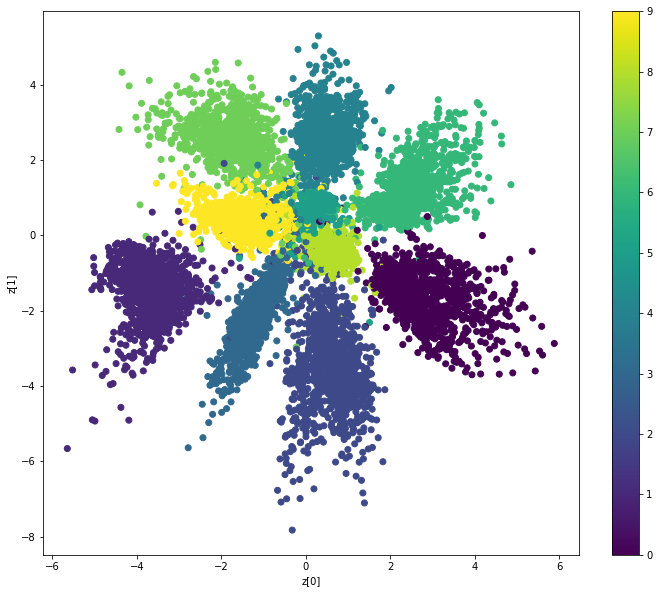

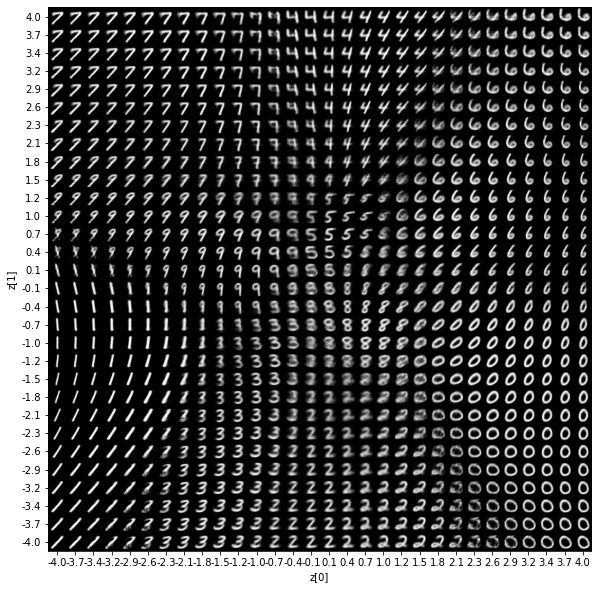

In [6]:
plot_results(models,
                data,
                batch_size=batch_size,
                model_name="vae_mlp")